# TD vs MC Prediction

This code implements and compares two fundamental reinforcement learning algorithms, Temporal-Difference (TD) learning and Monte Carlo (MC) prediction, on a simple "Random Walk" environment.

## Imports and Environment Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from collections import defaultdict
import gym  

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.



This class defines a simple 7-state random walk environment, a classic problem from Sutton and Barto's "Reinforcement Learning" textbook.

  * **States:** `[ 0, 1, 2, 3, 4, 5, 6 ]`
  * **Labels:** `[ T, A, B, C, D, E, T ]`
  * **Details:**
      * States 0 and 6 are **terminal states (T)**.
      * The episode always **starts in state 3 (C)**.
      * **Actions** are 0 (left) or 1 (right).
      * **Rewards** are 0 for all transitions, *except* for the transition into terminal state 6, which gives a **reward of +1**.
  * **True Values:** `V_true` represents the theoretical true value of each state under a 50/50 random policy, which is the probability of ending in state 6 (and getting +1) from that state.
 

In [2]:
class LinearEnv:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.reset()

    def reset(self):
        self._state = 3  # Always start in state C
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')

        if action == 0: self._state -= 1  # Move left
        if action == 1: self._state += 1  # Move right
            
        reward = 0
        if self._state < 1:  # Terminal state 0
            self._done = True
        if self._state > 5:  # Terminal state 6
            self._done = True
            reward = 1
                
        return self._state, reward, self._done  # obs, rew, done

# Initialize the environment
env = LinearEnv()

# Define the simple random policy (50% chance left, 50% right)
def policy(state):
    return np.random.choice([0, 1])

## Algorithm 1: Temporal-Difference (TD) Prediction

This function, `td_prediction_ext`, implements **TD(0) learning**.

  * **Core Idea:** TD learning updates its value estimate for a state `V[S]` based on the reward received `R` and the *estimated* value of the *next* state `V[S_]`.
  * **Bootstrapping:** This method is called "bootstrapping" because it updates its guess based on another guess (`V[S_]`).
  * **Update Rule:** `V[S] = V[S] + alpha * (R + gamma * V[S_] - V[S])`
  * **`alpha` (α):** The learning rate.

In [3]:
def td_prediction_ext(env, policy, ep, gamma, alpha, V_init=None):

    assert 0 < alpha <= 1
    
    # Allow initialization to arbitrary values (e.g., all 0.5)
    if V_init is not None:  V = V_init.copy()
    else:                   V = defaultdict(float)  # Default value 0
    
    V_hist = []  # To store value estimates over time
    
    for _ in range(ep):
        S = env.reset()
        while True:
            A = policy(S)
            S_, R, done = env.step(A)
            
            # The core TD(0) update
            V[S] = V[S] + alpha * (R + gamma * V[S_] - V[S])
            
            S = S_
            if done: break
        
        # Record the value function at the end of this episode
        V_arr = [V[i] for i in range(7)]
        V_hist.append(V_arr)
                
    return V, np.array(V_hist)

## Algorithm 2: Monte Carlo (MC) Prediction

This function, `mc_prediction_ext`, implements **every-visit Monte Carlo prediction**.

  * **Core Idea:** MC learning waits until the end of an episode. It then calculates the total discounted return `G` for *every* state `St` visited in that episode and updates the state's value `V[St]` toward that observed return.
  * **No Bootstrapping:** It uses the *actual* final return, not an estimate from the next state.
  * **Update Rule:** `V[St] = V[St] + alpha * (G - V[St])`

In [4]:
def mc_prediction_ext(env, policy, ep, gamma, alpha, V_init=None):

    if V_init is not None:  V = V_init.copy()
    else:                   V = defaultdict(float)
    
    V_hist = []
    
    for _ in range(ep):
        # 1. Generate a full episode
        traj, T = generate_episode(env, policy)
        G = 0
        
        # 2. Work backward through the episode
        for t in range(T-1, -1, -1):
            St, _, _, _ = traj[t]
            _, Rt_1, _, _ = traj[t+1]  # Reward from the *next* step
            
            # 3. Calculate the return G
            G = gamma * G + Rt_1
            
            # 4. Update the value function (every-visit)
            V[St] = V[St] + alpha * (G - V[St])
            
        # Record the value function
        V_arr = [V[i] for i in range(7)]
        V_hist.append(V_arr)
        
    return V, np.array(V_hist)


In [5]:
def generate_episode(env, policy):
    """Helper function to run one full episode and record the trajectory."""
    trajectory = []
    done = True
    while True:
        if done:  St, Rt, done = env.reset(), None, False
        else:     St, Rt, done = env.step(At)
        
        At = policy(St)
        trajectory.append((St, Rt, done, At))
        if done:  break
        
    return trajectory, len(trajectory)-1

## Experiment 1: TD Value Estimation Convergence

This experiment shows how the **TD(0)** algorithm's value estimates converge toward the true values over time.

  * **Setup:** All non-terminal states are initialized with a value of **0.5**.
  * **Process:** We run TD(0) for 1, 10, and 100 episodes and plot the resulting value function for the non-terminal states (A-E).
  * **Observation:** You can see the estimates (red, green, blue lines) getting progressively closer to the true value (black line) as more episodes are run.

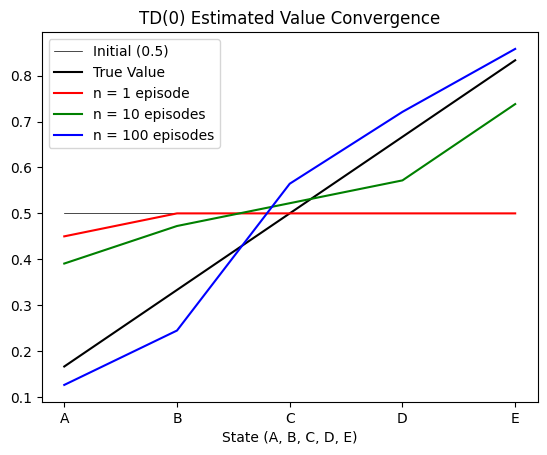

In [6]:
# Initialize all V(s) to 0.5, except terminal states (0.0)
V_init = defaultdict(lambda: 0.5)
V_init[0] = V_init[6] = 0.0

# Run TD prediction for 1, 10, and 100 episodes
V_n1, _ = td_prediction_ext(env, policy, ep=1, gamma=1.0, alpha=0.1, V_init=V_init)
V_n10, _ = td_prediction_ext(env, policy, ep=10, gamma=1.0, alpha=0.1, V_init=V_init)
V_n100, _ = td_prediction_ext(env, policy, ep=100, gamma=1.0, alpha=0.1, V_init=V_init)

def to_arr(V_dict):
    """Helper to convert the value dictionary to a numpy array."""
    V_arr = np.zeros(7)
    for st in range(7):
        V_arr[st] = V_dict[st]
    return V_arr

# Convert dicts to arrays for plotting
V_n1 = to_arr(V_n1)
V_n10 = to_arr(V_n10)
V_n100 = to_arr(V_n100)
    
# --- Plotting ---
fig = plt.figure()
ax = fig.add_subplot(111)
# Plot initial guess (0.5)
ax.plot(np.zeros([7])[1:-1]+0.5, color='black', linewidth=0.5, label='Initial (0.5)')
# Plot true values
ax.plot(LinearEnv.V_true[1:-1], color='black', label='True Value')
# Plot estimates
ax.plot(V_n1[1:-1], color='red', label='n = 1 episode')
ax.plot(V_n10[1:-1], color='green', label='n = 10 episodes')
ax.plot(V_n100[1:-1], color='blue', label='n = 100 episodes')

ax.set_title('TD(0) Estimated Value Convergence')
ax.set_xlabel('State (A, B, C, D, E)')
ax.set_xticks(range(5))
ax.set_xticklabels(['A', 'B', 'C', 'D', 'E'])
ax.legend()

plt.show()

## Experiment 2: TD vs. MC Learning Speed

This experiment compares the learning efficiency of TD and MC by plotting their **Root Mean Squared Error (RMSE)** over 100 episodes, averaged over 100 runs.

  * **Metric:** RMSE measures the average error between the algorithm's value estimates and the `V_true` across all non-terminal states. A lower RMSE is better.
  * **`run_experiment`:** This helper function automates the process of running an algorithm many times and calculating the average RMSE at each episode.
  * **Observation:** The resulting plot shows that **TD(0) (blue lines) generally converges much faster** (achieves lower error in fewer episodes) than MC (red lines) on this problem. It also highlights how the **learning rate (alpha)** affects performance for both methods.


In [7]:
def run_experiment(algorithm, nb_runs, env, ep, policy, gamma, alpha):
    """
    Runs an algorithm multiple times and computes the average RMSE
    at each episode.
    """
    # Start from the same initial V(s) = 0.5
    V_init = defaultdict(lambda: 0.5)
    V_init[0] = V_init[6] = 0.0

    V_runs = []
    for i in range(nb_runs):
        _, V_hist = algorithm(env, policy, ep, gamma=gamma, alpha=alpha, V_init=V_init)
        V_runs.append(V_hist)
    V_runs = np.array(V_runs)  # Dims: [nb_runs, nb_episodes, nb_states=7]
    
    # --- Calculate RMSE ---
    # 1. Remove terminal states (0 and 6)
    V_runs = V_runs[:,:,1:-1]
    # 2. Calculate error vs. true values
    error_to_true = V_runs - env.V_true[1:-1]
    # 3. Square and average over states
    squared_error = np.power(error_to_true, 2)
    mean_squared_error = np.average(squared_error, axis=-1)  # Avg over states
    # 4. Root
    root_mean_squared_error = np.sqrt(mean_squared_error)
    # 5. Average the RMSE across all runs
    rmse_avg_over_runs = np.average(root_mean_squared_error, axis=0)
    
    return rmse_avg_over_runs  # Data for one line on the plot


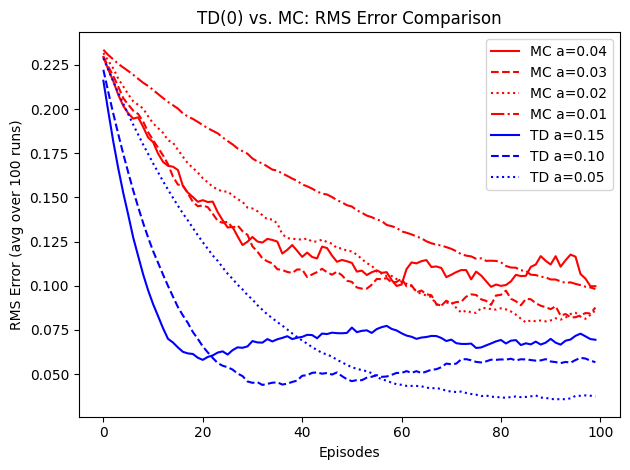

In [8]:
# --- Run the experiments for different alphas ---
nb_episodes = 100
nb_runs = 100

# TD runs
rmse_td_a15 = run_experiment(td_prediction_ext, nb_runs, env, nb_episodes, policy, 1.0, 0.15)
rmse_td_a10 = run_experiment(td_prediction_ext, nb_runs, env, nb_episodes, policy, 1.0, 0.10)
rmse_td_a05 = run_experiment(td_prediction_ext, nb_runs, env, nb_episodes, policy, 1.0, 0.05)

# MC runs
rmse_mc_a04 = run_experiment(mc_prediction_ext, nb_runs, env, nb_episodes, policy, 1.0, 0.04)
rmse_mc_a03 = run_experiment(mc_prediction_ext, nb_runs, env, nb_episodes, policy, 1.0, 0.03)
rmse_mc_a02 = run_experiment(mc_prediction_ext, nb_runs, env, nb_episodes, policy, 1.0, 0.02)
rmse_mc_a01 = run_experiment(mc_prediction_ext, nb_runs, env, nb_episodes, policy, 1.0, 0.01)

# --- Plotting ---
fig = plt.figure()
ax = fig.add_subplot(111)

# MC lines (red)
ax.plot(rmse_mc_a04, color='red', linestyle='-', label='MC a=0.04')
ax.plot(rmse_mc_a03, color='red', linestyle='--', label='MC a=0.03')
ax.plot(rmse_mc_a02, color='red', linestyle=':', label='MC a=0.02')
ax.plot(rmse_mc_a01, color='red', linestyle='-.', label='MC a=0.01') # Changed style for clarity

# TD lines (blue)
ax.plot(rmse_td_a15, color='blue', linestyle='-', label='TD a=0.15')
ax.plot(rmse_td_a10, color='blue', linestyle='--', label='TD a=0.10')
ax.plot(rmse_td_a05, color='blue', linestyle=':', label='TD a=0.05')

ax.set_title('TD(0) vs. MC: RMS Error Comparison')
ax.set_xlabel('Episodes')
ax.set_ylabel('RMS Error (avg over 100 runs)')
ax.legend()
plt.tight_layout()
plt.show()